# Skin Lesion Boundary Segmentation using Computer Vision (opencv)

Skin cancer is a major public health problem, with over 5,000,000 newly diagnosed cases in the United States every year. Melanoma is the deadliest form of skin cancer, responsible for an overwhelming majority of skin cancer deaths. In 2015, the global incidence of melanoma was estimated to be over 350,000 cases, with almost 60,000 deaths. Although the mortality is significant, when detected early, melanoma survival exceeds 95%.

This Challenge is taken from ISIC 2018 competetion. 

It contains various challenges one of which is to Submit automated predictions of lesion segmentation boundaries within dermoscopic images.

In this notebook we will try to tackle this problem using Computer Vision based operations. This will help us gain better understanding of the images and also help us exploring data well. After that we will try using Deep learning based techniques

In [7]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
%matplotlib inline

Define the path and read a sample image

In [8]:
PATH = r"D:/Work/DL_learn/Datasets/SkinCancer/Images/"

In [244]:
img = cv2.imread(os.path.join(PATH,'ISIC_0000243.jpg'))

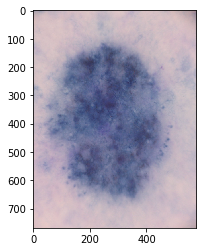

In [245]:
plt.imshow(img)

Most open cv based techniques can be easily applied when image is present in Grayscale format. So we will perform below operations

1. First we will apply some smoothing to reduce the noise in the image/ smooth the image.
2. Then we will connvert it to grayscale format
3. Later we will apply some thresholding to convert image into a binary mask

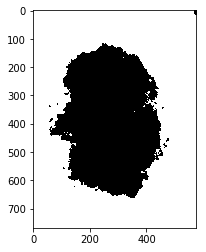

In [250]:
blurred = cv2.GaussianBlur(img,(5,5) ,0) # Smaoothing 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)# Grayscale convertion
thresh = cv2.threshold(gray, 145, 255, cv2.THRESH_BINARY)[1] # Thresholding
plt.imshow(thresh,cmap = 'gray')

After Thresholding we have a lot of the unfilled spaces. i.e image mask is not continous. So we will apply some morphological operations to make it more continuous

4. Apply a 2D Filter
5. Perform Openinig Morph operation
6. Perform Closing Morph operation


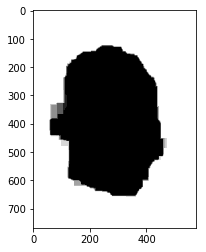

In [252]:
filkernel = np.ones((5, 5), np.float32) / 25
filtered = cv2.filter2D(thresh, -1, filkernel)
openkernel = np.ones((35,35),np.uint8)
opening = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, openkernel)
closekernel = np.ones((35,35),np.uint8)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, closekernel)
plt.imshow(closing,cmap = 'gray')

As you can see the gaps are now closed and image mask is more continuous. Now we are ready for applying Edge Algorithms

7. We will apply Canny Edge detection to detect edges

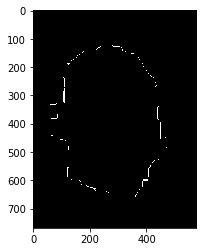

In [253]:
edged = cv2.Canny(closing, 144, 255)
plt.imshow(edged,cmap = 'gray')

Canny Edge has done a good (although not very well) job of detecting the lesion boundary. 

8. Now as a last step we will find the contours in image
9. Filter Countours based on thier area to neglect some of the small regions

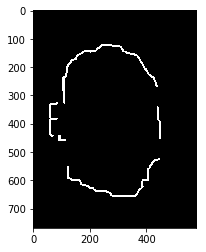

In [254]:
 _,contours,_ = cv2.findContours(edged,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros(img.shape, np.uint8)
filtered_contours = []
for cnt in contours:
    if cv2.contourArea(cnt) >= 3:
        filtered_contours.append(cnt)
cv2.drawContours(mask, filtered_contours, -1, (255,255,255), 5)
plt.imshow(mask,cmap = 'gray')

10. Apply contour mask over the image to generate the segmentation boundary

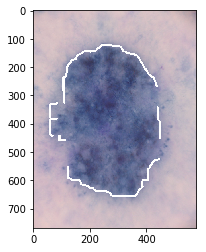

In [256]:
mask_not = cv2.bitwise_not(mask)
mask = cv2.bitwise_or(mask,img)
plt.imshow(mask)

In [261]:
def get_maskcv(img):
    # Thresholding and Blurring
    blurred = cv2.GaussianBlur(img,(5,5) ,0)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 145, 255, cv2.THRESH_BINARY)[1]
    # Morph operations
    filkernel = np.ones((5, 5), np.float32) / 25
    filtered = cv2.filter2D(thresh, -1, filkernel)
    openkernel = np.ones((35,35),np.uint8)
    opening = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, openkernel)
    closekernel = np.ones((35,35),np.uint8)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, closekernel)
    #Edge Detection
    edged = cv2.Canny(closing, 144, 255)
    # Contour detection
    _,contours,_ = cv2.findContours(edged,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(img.shape, np.uint8)
    filtered_contours = []
    for cnt in contours:
        if cv2.contourArea(cnt) >= 3:
            filtered_contours.append(cnt)
    cv2.drawContours(mask, filtered_contours, -1, (255,255,255), 5)
    mask_not = cv2.bitwise_not(mask)
    mask = cv2.bitwise_or(mask,img)
    return mask

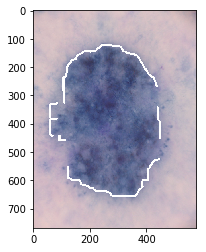

In [247]:
plt.imshow(get_maskcv(img),cmap = 'gray')

Now lets check this for some simple images

In [263]:
img_list = ['ISIC_0000001.jpg','ISIC_0000013.jpg','ISIC_0000020.jpg','ISIC_0000022.jpg','ISIC_0000607.jpg','ISIC_0000253.jpg']

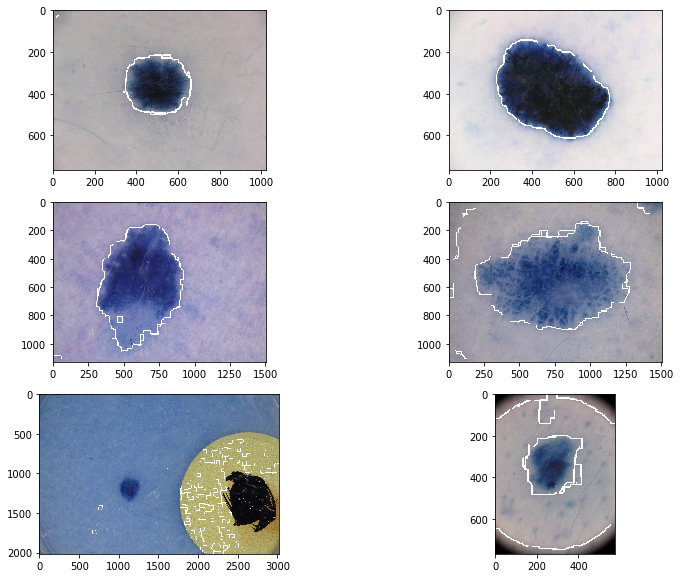

In [276]:
fig,axes = plt.subplots(nrows=3,ncols=2,figsize = (13,10))
cnt = 0
for i in range(3):
    for j in range(2):
        t_img = cv2.imread(os.path.join(PATH,img_list[cnt]))
        axes[i][j].imshow(get_maskcv(t_img))
        cnt+=1

As we can see for the images where Tumor is visible directly in field of view without any other object this method works well, however in case of a different image where there is other object present/circular images we are not able to identify the segments properly & we may need to resort to more advanced methods 